# Climb tracker

In [25]:
%pip install -q -r "../../requirements.txt"

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: C:\Users\mstol\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


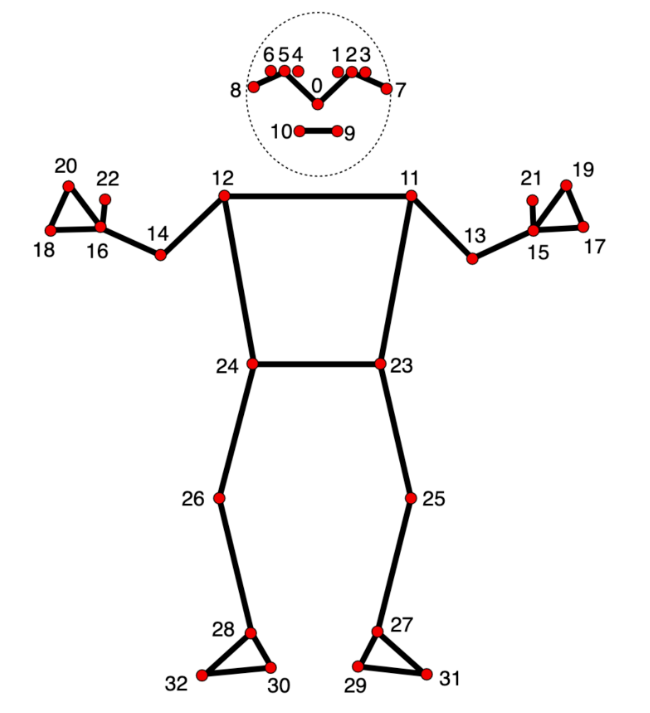

In [1]:
import mediapipe as mp
import cv2
import numpy as np
from time import perf_counter

# MediaPipe setup
BaseOptions = mp.tasks.BaseOptions
PoseLandmarker = mp.tasks.vision.PoseLandmarker
PoseLandmarkerOptions = mp.tasks.vision.PoseLandmarkerOptions
VisionRunningMode = mp.tasks.vision.RunningMode

# Pose landmarks configuration
LIMB_KEYPOINTS = {
    "left_hand": 15,
    "right_hand": 16,
    "left_foot": 31,
    "right_foot": 32
}

POSE_CONNECTIONS = [
    (0, 1), (1, 2), (2, 3), (3, 7), (0, 4), (4, 5), (5, 6), (6, 8),
    (9, 10), (11, 12), (11, 13), (13, 15), (15, 17), (15, 19), (15, 21),
    (12, 14), (14, 16), (16, 18), (16, 20), (16, 22), (11, 23), (12, 24),
    (23, 24), (23, 25), (25, 27), (27, 29), (29, 31), (27, 31), (24, 26),
    (26, 28), (28, 30), (28, 32), (30, 32)
]

# Climbing route configuration
PATH = {
    0: (260, 900),
    1: (255, 770),
    2: (277, 745),
    3: (370, 645),
    4: (300, 595),
    5: (344, 462),
    6: (238, 400),
    7: (340, 365),
    8: (442, 268),
    9: (371, 243),
    10: (273, 162),
    11: (155, 53),
}

ALGORITHM = {
    0: {"move_destination": 2, "limb": "right_foot"},
    1: {"move_destination": 7, "limb": "right_hand"},
    2: {"move_destination": 7, "limb": "left_hand"},
    3: {"move_destination": 3, "limb": "right_foot"},
    4: {"move_destination": 4, "limb": "left_foot"},
    5: {"move_destination": 8, "limb": "right_hand"},
    6: {"move_destination": 9, "limb": "left_hand"},
    7: {"move_destination": 5, "limb": "left_foot"},
    8: {"move_destination": 9, "limb": "right_hand"},
    9: {"move_destination": 10, "limb": "left_hand"},
    10: {"move_destination": 5, "limb": "right_foot"},
    11: {"move_destination": 6, "limb": "left_foot"},
    12: {"move_destination": 10, "limb": "right_hand"},
    13: {"move_destination": 7, "limb": "right_foot"},
    14: {"move_destination": 11, "limb": "left_hand"},
    15: {"move_destination": 11, "limb": "right_hand"}
}

# Tracking parameters
MODEL_PATH = 'pose_landmarker_full.task'
MIN_CONTACT_TIME = 0.5
FRAME_RATE = 24
CONTACT_DISTANCE = 27

# Global state
current_step = 0
min_contact_frames = int(FRAME_RATE * MIN_CONTACT_TIME)
position_log = [-1e10] * min_contact_frames
algorithm_len = len(ALGORITHM)
completed = False
completed_holds = set()
current_message = ""


def image_coords_to_px(landmark, frame_height, frame_width):
    """Convert normalized landmark coordinates to pixel coordinates."""
    x = round(landmark.x * frame_width)
    y = round(landmark.y * frame_height)
    return x, y


def track_progress(landmarks, frame_height, frame_width):
    """Track climber's progress through the route."""
    global current_step, position_log, completed, completed_holds, current_message
    
    if completed:
        return
    
    current_move = ALGORITHM[current_step]
    move_destination = current_move["move_destination"]
    limb = current_move["limb"]
    destination_coords = PATH[move_destination]
    
    last_positions = position_log[-min_contact_frames:]
    distances = [np.linalg.norm(np.array(destination_coords) - np.array(pos)) 
                 for pos in last_positions]
    move_completed = np.mean(distances) < CONTACT_DISTANCE
    
    if current_step == algorithm_len - 1:
        print("Path completed, congratulations!")
        completed_holds.add(move_destination)
        current_message = "Path completed, congratulations!"
        completed = True
    elif move_completed:
        completed_holds.add(move_destination)
        current_step += 1
        position_log = []
        
        if current_step < algorithm_len:
            next_move = ALGORITHM[current_step]
            next_limb = next_move["limb"]
            next_destination = next_move["move_destination"]
            current_message = f"Next move: {next_limb} => {next_destination}"
            print(f"Move detected! Next move: {next_limb} => {next_destination}")
    else:
        limb_landmark = landmarks[LIMB_KEYPOINTS[limb]]
        position_log.append(image_coords_to_px(limb_landmark, frame_height, frame_width))


def draw_hold(frame, x, y, idx, completed):
    """Draw a single climbing hold."""
    if completed:
        fill_color = (50, 205, 50)
        border_color = (34, 139, 34)
        outer_glow = (100, 255, 100)
    else:
        fill_color = (255, 140, 0)
        border_color = (200, 100, 0)
        outer_glow = (255, 180, 80)
    
    cv2.circle(frame, (x, y), 22, outer_glow, 2)
    cv2.circle(frame, (x, y), 18, fill_color, -1)
    cv2.circle(frame, (x, y), 18, border_color, 3)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(frame, str(idx), (x - 7, y + 6), font, 0.7, (0, 0, 0), 3)
    cv2.putText(frame, str(idx), (x - 8, y + 5), font, 0.7, (255, 255, 255), 2)


def draw_pose_skeleton(frame, landmarks):
    """Draw the pose skeleton with highlighted limbs."""
    h, w = frame.shape[:2]
    
    landmark_points = [(int(lm.x * w), int(lm.y * h)) for lm in landmarks]
    
    for start_idx, end_idx in POSE_CONNECTIONS:
        if start_idx < len(landmark_points) and end_idx < len(landmark_points):
            cv2.line(frame, landmark_points[start_idx], 
                    landmark_points[end_idx], (0, 255, 0), 2)
    
    for point in landmark_points:
        cv2.circle(frame, point, 4, (255, 255, 255), -1)
        cv2.circle(frame, point, 4, (0, 255, 0), 1)
    
    for name, idx in LIMB_KEYPOINTS.items():
        if idx < len(landmark_points):
            point = landmark_points[idx]
            cv2.circle(frame, point, 10, (0, 165, 255), -1)
            cv2.circle(frame, point, 10, (0, 100, 200), 2)
            cv2.putText(frame, name.replace('_', ' '), 
                       (point[0] + 15, point[1] - 5),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 165, 255), 2)


def draw_message(frame, message):
    """Draw message banner at the bottom of the frame."""
    if not message:
        return
    
    h, w = frame.shape[:2]
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1.2
    thickness = 2
    text_size = cv2.getTextSize(message, font, font_scale, thickness)[0]
    
    text_x = (w - text_size[0]) // 2
    text_y = h - 30
    
    padding = 10
    rect_start = (text_x - padding, text_y - text_size[1] - padding)
    rect_end = (text_x + text_size[0] + padding, text_y + padding)
    
    overlay = frame.copy()
    cv2.rectangle(overlay, rect_start, rect_end, (0, 0, 0), -1)
    cv2.addWeighted(overlay, 0.7, frame, 0.3, 0, frame)
    
    cv2.putText(frame, message, (text_x, text_y), font, font_scale, 
               (255, 255, 255), thickness)


def draw_frame(frame, landmarks=None):
    """Draw complete annotated frame."""
    annotated = frame.copy()
    
    for idx, (x, y) in PATH.items():
        draw_hold(annotated, x, y, idx, idx in completed_holds)
    
    if landmarks:
        draw_pose_skeleton(annotated, landmarks)
    
    draw_message(annotated, current_message)
    
    return annotated


def main():
    """Main video processing loop."""
    input_video = "climbing_sample_cut.mp4"
    output_video = "climbing_tracker_output.mp4"
    
    cap = cv2.VideoCapture(input_video)
    
    fps = cap.get(cv2.CAP_PROP_FPS)
    if fps <= 0:
        raise RuntimeError("Failed to read FPS from video")
    
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_duration_ms = 1000.0 / fps
    frame_count = 0
    
    # Setup video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video, fourcc, fps, (frame_width, frame_height))
    
    print(f"Video FPS: {fps}")
    print(f"Frame duration: {frame_duration_ms:.2f}ms")
    print(f"Resolution: {frame_width}x{frame_height}")
    print(f"Output file: {output_video}")
    print("Press 'q' to quit")
    
    options = PoseLandmarkerOptions(
        base_options=BaseOptions(model_asset_path=MODEL_PATH),
        running_mode=VisionRunningMode.VIDEO,
    )
    
    with PoseLandmarker.create_from_options(options) as landmarker:
        while True:
            frame_start = perf_counter()
            
            ret, frame = cap.read()
            if not ret:
                break
            
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame_rgb)
            timestamp_ms = int(frame_count * frame_duration_ms)
            
            result = landmarker.detect_for_video(mp_image, timestamp_ms)
            
            if result.pose_landmarks:
                landmarks = result.pose_landmarks[0]
                track_progress(list(landmarks), mp_image.height, mp_image.width)
                annotated_frame = draw_frame(frame, landmarks)
            else:
                annotated_frame = draw_frame(frame)
            
            cv2.putText(annotated_frame, f"Frame: {frame_count}", 
                       (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
            
            # Write frame to output video
            out.write(annotated_frame)
            
            cv2.imshow("Climbing Pose Tracker", annotated_frame)
            
            processing_time_ms = (perf_counter() - frame_start) * 1000.0
            wait_ms = max(int(frame_duration_ms - processing_time_ms), 1)
            
            if cv2.waitKey(wait_ms) & 0xFF == ord('q'):
                break
            
            frame_count += 1
    
    cap.release()
    out.release()
    cv2.destroyAllWindows()
    print(f"\nProcessed {frame_count} frames")
    print(f"Output saved to: {output_video}")


if __name__ == "__main__":
    main()

Video FPS: 24.0
Frame duration: 41.67ms
Resolution: 576x1024
Output file: climbing_tracker_output.mp4
Press 'q' to quit
Move detected! Next move: right_hand => 7


C:\Users\mstol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\mstol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Move detected! Next move: left_hand => 7
Move detected! Next move: right_foot => 3
Move detected! Next move: left_foot => 4
Move detected! Next move: right_hand => 8
Move detected! Next move: left_hand => 9
Move detected! Next move: left_foot => 5
Move detected! Next move: right_hand => 9
Move detected! Next move: left_hand => 10
Move detected! Next move: right_foot => 5
Move detected! Next move: left_foot => 6
Move detected! Next move: right_hand => 10
Move detected! Next move: right_foot => 7
Move detected! Next move: left_hand => 11
Move detected! Next move: right_hand => 11
Path completed, congratulations!

Processed 641 frames
Output saved to: climbing_tracker_output.mp4
